In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

# Data
TensorFlow has the food 101 dataset already. We will use this! https://www.tensorflow.org/datasets/catalog/food101

Hot dog is label 55

In [2]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZA55BZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZA55BZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
train_ds, valid_ds = ds["train"], ds["validation"]

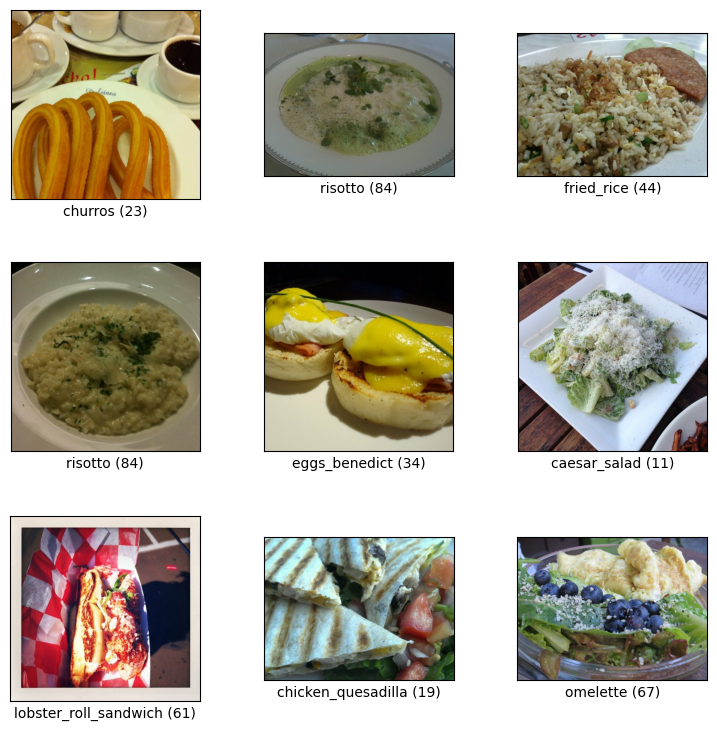

In [4]:
fig = tfds.show_examples(train_ds, ds_info)

In [5]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32),
                          tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

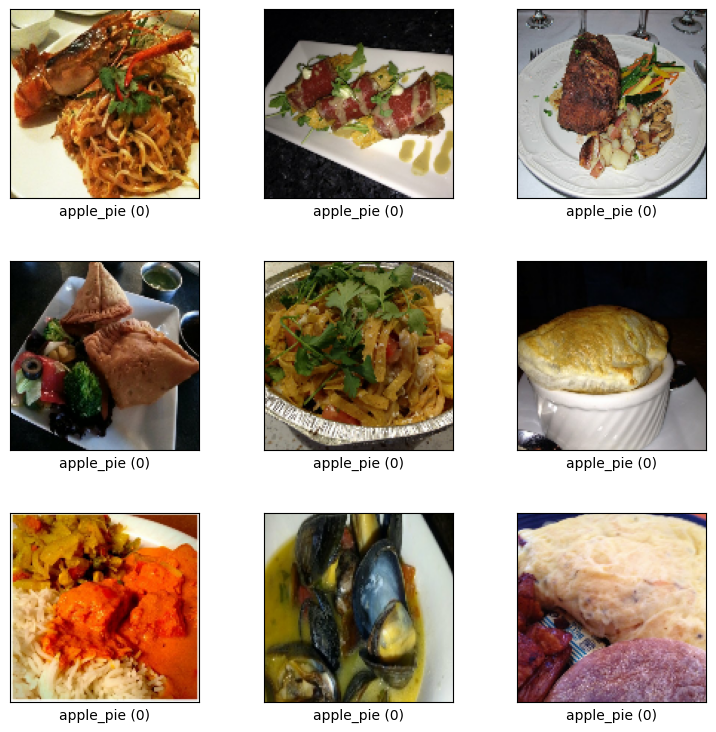

In [6]:
fig = tfds.show_examples(train_ds, ds_info)

In [7]:
train_hd_size, valid_hd_size = 750, 250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda image, label: label == 0)

In [8]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda image, label: label == 0)

In [9]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                [0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [10]:
for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[253 255 254]
   [253 254 253]
   [254 254 252]
   ...
   [254 254 254]
   [255 255 255]
   [255 255 255]]

  [[253 254 253]
   [253 255 254]
   [253 255 254]
   ...
   [252 252 252]
   [253 253 253]
   [255 255 255]]

  [[255 255 253]
   [253 255 254]
   [236 240 241]
   ...
   [ 30  30  30]
   [254 254 254]
   [255 255 255]]

  ...

  [[254 254 252]
   [253 253 250]
   [125 120 116]
   ...
   [114 114 117]
   [254 254 254]
   [255 255 253]]

  [[255 255 253]
   [252 254 251]
   [253 253 250]
   ...
   [252 252 252]
   [254 254 254]
   [255 255 254]]

  [[254 255 253]
   [252 255 253]
   [250 254 251]
   ...
   [254 254 252]
   [254 254 253]
   [255 255 255]]]


 [[[  0   7   6]
   [  0   6   6]
   [  0   4   5]
   ...
   [115 151 208]
   [115 153 208]
   [118 158 208]]

  [[  0   5   4]
   [  2   8   8]
   [  0   4   5]
   ...
   [111 146 202]
   [109 146 200]
   [112 151 201]]

  [[  0   6   5]
   [  1   7   7]
   [  1   6   6]
   ...
   [116 150 205]
   [111 147 200]


# Neural Network Implementation

In [11]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=[MAX_SIDE_LEN, MAX_SIDE_LEN, 3]))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

In [12]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs
)

Epoch 1/15
287/287 [==============================] - 1071s 4s/step - loss: 0.6662 - accuracy: 0.5500 - val_loss: 0.6145 - val_accuracy: 0.6736
Epoch 2/15
287/287 [==============================] - 486s 2s/step - loss: 0.5689 - accuracy: 0.6743 - val_loss: 0.5764 - val_accuracy: 0.6816
Epoch 3/15
287/287 [==============================] - 482s 2s/step - loss: 0.4553 - accuracy: 0.7688 - val_loss: 0.5840 - val_accuracy: 0.6936
Epoch 4/15
287/287 [==============================] - 491s 2s/step - loss: 0.3475 - accuracy: 0.8399 - val_loss: 0.6239 - val_accuracy: 0.6729
Epoch 5/15
287/287 [==============================] - 492s 2s/step - loss: 0.2518 - accuracy: 0.8951 - val_loss: 0.7403 - val_accuracy: 0.6348
Epoch 6/15
287/287 [==============================] - 493s 2s/step - loss: 0.1746 - accuracy: 0.9354 - val_loss: 0.9361 - val_accuracy: 0.6355
Epoch 7/15
287/287 [==============================] - 485s 2s/step - loss: 0.1117 - accuracy: 0.9673 - val_loss: 1.0345 - val_accuracy: 0.637